In [1]:
import requests
import pandas as pd
import json
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns

In [2]:
#get stations data, filter for CA
api_key = 'vD3YcIQ4aCof8MDagGScFZRFlGg9fVvpw1SJbvwv'

def get_charging_stations(api_key, fuel_type='ELEC', state=None, limit=10):
    base_url = 'https://developer.nrel.gov/api/alt-fuel-stations/v1.json'
    params = {
        'api_key': api_key,
        'fuel_type': fuel_type,
        'limit': limit,
        'state': state
    }
    response = requests.get(base_url, params=params)
    results = response.text
    data = response.json()
    filtered_data = data['fuel_stations']
    fuel_stations = pd.json_normalize(filtered_data,sep='_')
    return fuel_stations

charging_stations = get_charging_stations(api_key, state='CA', limit='all')

In [3]:
#drop columns, filter only public
charging_stations_simple = charging_stations[["access_code", "access_days_time", "date_last_confirmed", "fuel_type_code", "groups_with_access_code", "id", "open_date", "facility_type", "station_name", "latitude", "longitude", "city", "country", "street_address", "zip"]]
charging_stations_public = charging_stations_simple[charging_stations_simple['access_code'] == 'public'].copy()

In [4]:
charging_stations_public['zip'] = pd.to_numeric(charging_stations_public['zip'], errors='coerce')

In [5]:
# get data

#zev registrations and filter by electric
vehicle_county_temp = pd.read_csv("/Users/kerinapatel/desktop/CP255/Final project/Vehicles_County.csv")
ev_county = vehicle_county_temp[vehicle_county_temp['Fuel Type'] == "Battery Electric (BEV)"].copy()

#zev reg by zip and filter by elec
vehicle_zip_temp = pd.read_csv("/Users/kerinapatel/desktop/CP255/Final project/Vehicles_Zip.csv")
ev_zip = vehicle_zip_temp[vehicle_zip_temp['Fuel Type'] == "Battery Electric (BEV)"].copy()

#get CES data
calenviroscreen = pd.read_csv("/Users/kerinapatel/desktop/CP255/Final project/calenviroscreen_tracts.csv")
calenviroscreen.rename(columns={'ZIP': 'zip'}, inplace=True)

#get counties shp
california_counties = gpd.read_file('/Users/kerinapatel/desktop/CP255/Final project/ca_county_boundaries/ca_county_boundaries.shp')

In [6]:
##working on vehicle bar chart
# Prep make level data on vehicles by filtering for 2022 data 
vehicles_county_2022 = vehicle_county_temp[vehicle_county_temp['Data Year'] == 2022].copy()

In [7]:
# collapse data so each make has 1 row with sum of number of vehicles
vehicles_2022_collapsed = vehicles_county_2022.groupby('Fuel Type')['Number of Vehicles'].sum().reset_index()

# get top 5 makes
sorted_vehicles = vehicles_2022_collapsed.sort_values(by='Number of Vehicles', axis=0, ascending=False)
sorted_vehicles['Vehicles in Thousands'] = sorted_vehicles['Number of Vehicles']/1000
top5_fuels = sorted_vehicles.head()

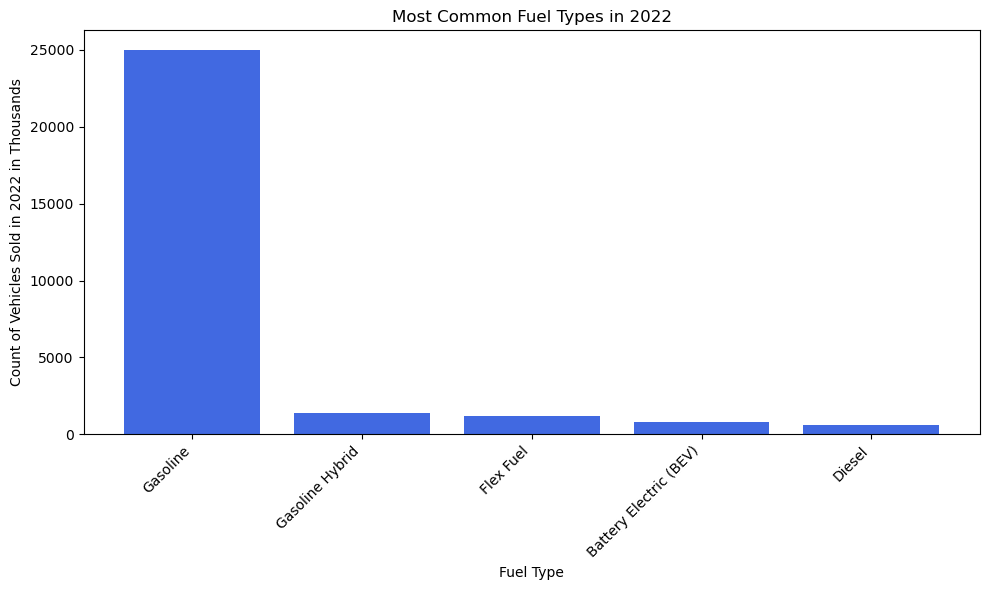

In [8]:
## bar chart of top public facility types
plt.figure(figsize=(10, 6))
plt.bar(top5_fuels['Fuel Type'], top5_fuels['Vehicles in Thousands'], color='royalblue')
plt.xlabel('Fuel Type')
plt.ylabel('Count of Vehicles Sold in 2022 in Thousands')
plt.title('Most Common Fuel Types in 2022')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show() 

In [9]:
##working on chrg bar chart
# collapse charging stations so only 1 row per zip
charge_zip_collapsed = charging_stations.groupby('zip').size().reset_index(name='Number of Chargers')

In [10]:
#drop unnecessary column and filter only public chargers
charging_stations_simple = charging_stations[["access_code", "access_days_time", "date_last_confirmed", "fuel_type_code", "groups_with_access_code", "id", "open_date", "facility_type", "station_name", "latitude", "longitude", "city", "country", "street_address", "zip"]]
charging_stations_public = charging_stations_simple[charging_stations_simple['access_code'] == 'public'].copy()
charging_stations_public_zipnum = charging_stations_public.copy()
charging_stations_public_zipnum['zip'] = pd.to_numeric(charging_stations_public_zipnum['zip'], errors='coerce')

In [11]:
# pivot table chargers by facility type
chrgrs_by_type = pd.pivot_table(charging_stations, values='id', index=['facility_type'],
                       columns=['access_code'], aggfunc="count", fill_value=0)

# get top 5 public facility types
sorted_chrg_pivot = chrgrs_by_type.sort_values(by='public', axis=0, ascending=False)

# drop private column
top_public_fac=sorted_chrg_pivot.drop(columns=['private']).head()

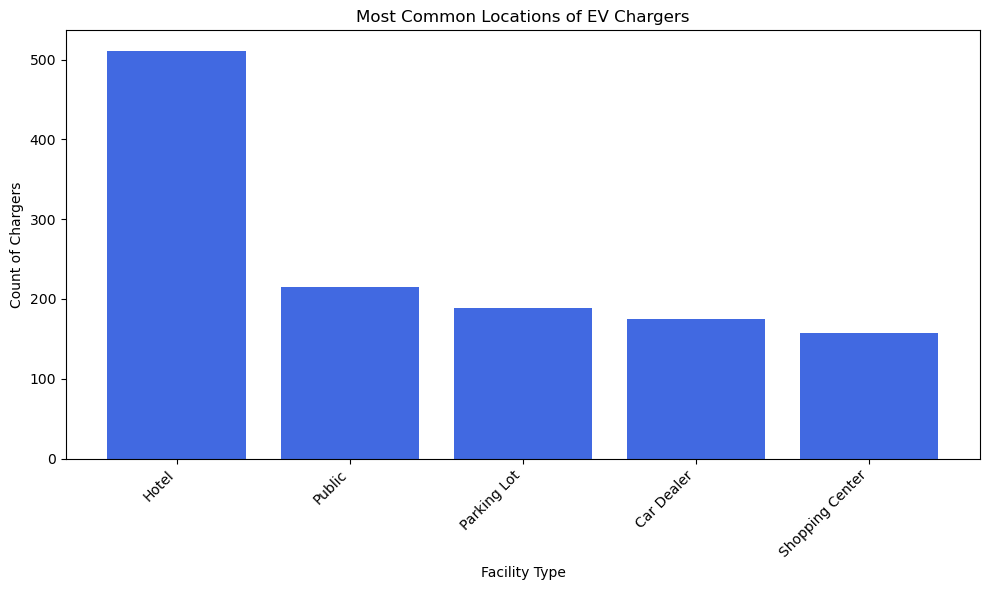

In [12]:
##chart of top public charging facility types

# fixing data axes
pivot_fix = {
    'facility_type': ['Hotel', 'Public', 'Parking Lot', 'Car Dealer', 'Shopping Center'],
    'public_count': [511, 215, 189, 175, 157]
}
public_fac_top5 = pd.DataFrame(pivot_fix)

# bar chart of top public facility types
plt.figure(figsize=(10, 6))
plt.bar(public_fac_top5['facility_type'], public_fac_top5['public_count'], color='royalblue')
plt.xlabel('Facility Type')
plt.ylabel('Count of Chargers')
plt.title('Most Common Locations of EV Chargers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show() 

In [13]:
# EV registration over time prep 
# Calculate percent of EV per year 
ev_county_collapsed = ev_county.groupby('Data Year')['Number of Vehicles'].sum().reset_index()
total_county_collapsed = vehicle_county_temp.groupby('Data Year')['Number of Vehicles'].sum().reset_index()
percentage_ev_by_year = (ev_county_collapsed['Number of Vehicles'] / total_county_collapsed['Number of Vehicles']) * 100

percentage_ev_by_year = pd.concat([percentage_ev_by_year, ev_county_collapsed['Data Year']], axis=1)
percentage_ev_by_year.set_index('Data Year', inplace=True)

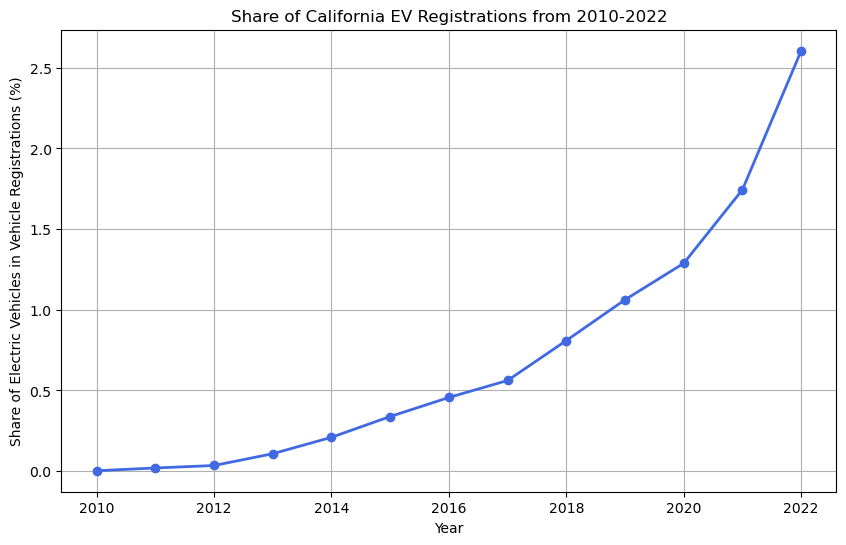

In [47]:
plt.figure(figsize=(10, 6)) 
plt.plot(percentage_ev_by_year.index, percentage_ev_by_year['Number of Vehicles'], marker='o', color='royalblue', linestyle='-', linewidth=2, markersize=6)

plt.xlabel('Year')
plt.ylabel('Share of Electric Vehicles in Vehicle Registrations (%)')
plt.title('Share of California EV Registrations from 2010-2022')
plt.grid(True)

plt.show()


In looking at the number of EVs in the state of California from 1998 to 2023, we saw a sharp increase in the adoption of EVs in the past decade. This follows based on technological advances, improving affordability of EVs, and policy changes encouraging electrification.

In [15]:
## Working on ev by chrg scatterplot
# Prep zip code and county level level data on EVs by filtering for 2022 data

# Zip code level 
## ALL CARS IN 2022:
vehicles_zip_2022 = vehicle_zip_temp[vehicle_zip_temp['Data Year'] == 2022].copy()
vehicles_zip_2022.rename(columns={'ZIP': 'zip'}, inplace=True)
## EVs in 2022:
ev_zip_2022 = ev_zip[ev_zip['Data Year'] == 2022].copy()
ev_zip_2022.rename(columns={'ZIP': 'zip'}, inplace=True)

# County level 
## ALL CARS IN 2022:
# vehicles_county_2022 
## EVs in 2022:
ev_county_2022 = ev_county[ev_county['Data Year'] == 2022].copy()

# Calculate percent EVs for each zip code
ev_zip_collapsed = ev_zip_2022.groupby('zip')['Number of Vehicles'].sum()
total_zip_collapsed = vehicles_zip_2022.groupby('zip')['Number of Vehicles'].sum()

percentage_ev_by_zip = (ev_zip_collapsed / total_zip_collapsed) * 100
percentage_ev_by_zip = pd.concat([percentage_ev_by_zip, ev_zip_collapsed], axis=1, keys=['Percentage EVs', 'Number of EVs'])

# Calculate percent EVs for each county
ev_county_collapsed = ev_county_2022.groupby('County')['Number of Vehicles'].sum()
total_county_collapsed = vehicles_county_2022.groupby('County')['Number of Vehicles'].sum()

percentage_ev_by_county = (ev_county_collapsed / total_county_collapsed) * 100
percentage_ev_by_county = pd.concat([percentage_ev_by_county, ev_county_collapsed], axis=1, keys=['Percentage EVs', 'Number of EVs'])

In [17]:
## Chart showing count of EV chargers by count of EV registrations on a County level - add correlation line

# count number of EV chargers in each zip code
charging_stations_by_zip =  charging_stations_public_zipnum.groupby('zip').size().reset_index(name='Number of Chargers')
charging_stations_by_zip['zip'] = charging_stations_by_zip['zip'].astype(int)

# density of chargers by population density for ZIP CODES

# sum population to county level 
zip_population = calenviroscreen.groupby('zip')['Total Population'].sum().reset_index()
# Join to the charger data
chrgs_zip_withpop = charging_stations_by_zip.merge(zip_population, how='inner', left_on='zip', right_on='zip')
# calculate density
chrgs_by_pop_zip = chrgs_zip_withpop.copy() 
chrgs_by_pop_zip['EV Chargers Per Capita'] = chrgs_by_pop_zip['Number of Chargers'] / chrgs_by_pop_zip['Total Population']

# join EV chargers and EV registrations by zip code
all_ev_data = pd.merge(percentage_ev_by_zip, chrgs_by_pop_zip, on='zip', how='inner')

# subset only columns of interest
ev_data_simple = all_ev_data[["zip", "Percentage EVs", "EV Chargers Per Capita"]]
ev_data_simple2 = ev_data_simple.dropna()
## there are 2 infinite values of EV chargers per capita - presumably some zip codes didn't have populations so cannot use them. remove infinite values
ev_data_simple2_cleaned = ev_data_simple2.replace([np.inf, -np.inf], np.nan).dropna(how='any')

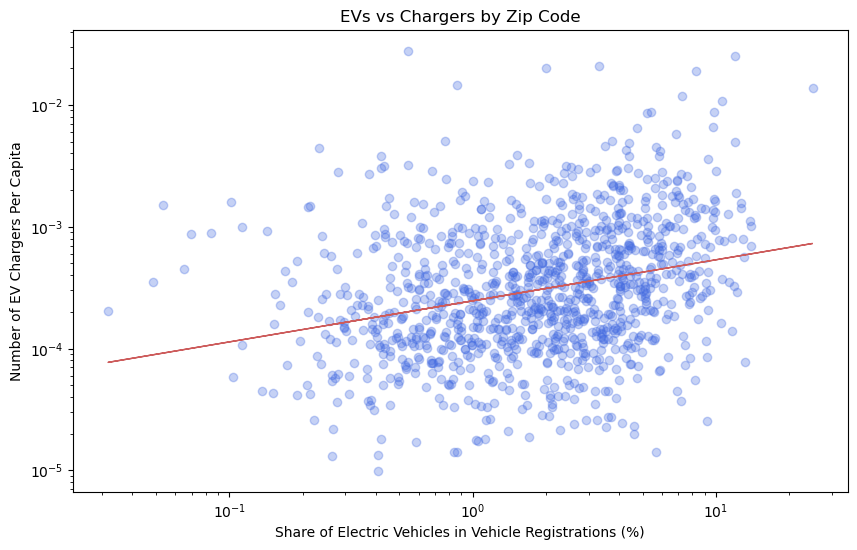

In [48]:
# Log-transform the data
x_log = np.log(ev_data_simple2_cleaned['Percentage EVs'])
y_log = np.log(ev_data_simple2_cleaned['EV Chargers Per Capita'])


slope_log, intercept_log = np.polyfit(x_log, y_log, 1)

plt.figure(figsize=(10, 6)) 
plt.scatter(ev_data_simple2_cleaned['Percentage EVs'], ev_data_simple2_cleaned['EV Chargers Per Capita'], marker='o', color='royalblue', alpha=0.3) 


plt.plot(ev_data_simple2_cleaned['Percentage EVs'], np.exp(intercept_log) * (ev_data_simple2_cleaned['Percentage EVs'] ** slope_log), color='indianred', linestyle='-', linewidth=1, label='Regression Line')

plt.xlabel('Share of Electric Vehicles in Vehicle Registrations (%)')
plt.ylabel('Number of EV Chargers Per Capita')
plt.title('EVs vs Chargers by Zip Code')

plt.xscale('log')
plt.yscale('log')

plt.show()

In [20]:
## getting CES data ready for scatterplot

#rename enviro zip column
calenviroscreen.rename(columns={'ZIP': 'zip'}, inplace=True)

#drop null CES scores
calenviroscreen.dropna(subset=['CES 4.0 Score'], inplace=True)

#collapse enviroscrn data by zip
calenviro_zip_collapsed = calenviroscreen.groupby('zip')['CES 4.0 Score'].mean().reset_index(name='Avg CES 4.0 Score')

In [21]:
##EDIT: avg chrgs per capita!
## scatterplot showing count of EV chargers by calenviroscreen score on a zip level - add correlation line, find R value? 


# count number of EV chargers in each zip code
# charging_stations_by_zip = charging_stations_public.groupby('zip').size().reset_index(name='Number of Chargers')

# Convert 'zip' column to string in both dfs
calenviro_zip_collapsed['zip'] = calenviro_zip_collapsed['zip'].astype(str)
chrgs_by_pop_zip['zip'] = chrgs_by_pop_zip['zip'].astype(str)

# join EV chargers and enviroscreen score by zip code
chrg_ces_score_zip = pd.merge(calenviro_zip_collapsed, chrgs_by_pop_zip, on='zip', how='inner')

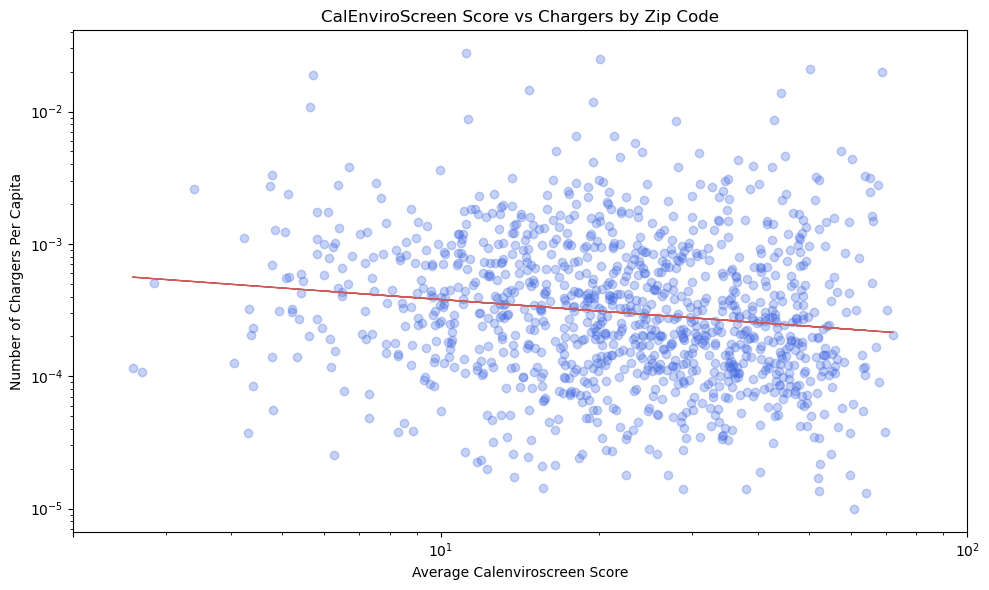

In [50]:
x_log = np.log(chrg_ces_score_zip['Avg CES 4.0 Score'])
y_log = np.log(chrg_ces_score_zip['EV Chargers Per Capita'])
slope_log, intercept_log = np.polyfit(x_log, y_log, 1)

plt.figure(figsize=(10, 6))
plt.scatter(chrg_ces_score_zip['Avg CES 4.0 Score'], chrg_ces_score_zip['EV Chargers Per Capita'], marker='o', color='royalblue', alpha=0.3)
plt.plot(chrg_ces_score_zip['Avg CES 4.0 Score'], np.exp(intercept_log) * (chrg_ces_score_zip['Avg CES 4.0 Score'] ** slope_log), color='indianred', linestyle='-', linewidth=1, label='Regression Line')

plt.xlabel('Average Calenviroscreen Score')
plt.ylabel('Number of Chargers Per Capita')
plt.title('CalEnviroScreen Score vs Chargers by Zip Code')

plt.xscale('log')
plt.yscale('log')

plt.xticks([2, 10, 100], ['', '$10^1$', '$10^2$'])
#plt.yticks([0.0001, 0.001, 0.01, 0.1], ['$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$'])



plt.tight_layout()
plt.show()

In [23]:
## Chloropleth of EV Registrations

In [24]:
#merge ev reg with county shp
ca_evs_2022 = california_counties.merge(percentage_ev_by_county, how='left', left_on='NAME', right_on='County')

In [25]:
# Density of EVs by population density!

# Get county id from GEOID
calenviroscreen['County ID'] = calenviroscreen['Census Tract'].astype(str).str[1:4]
# sum population to county level 
county_population = calenviroscreen.groupby('County ID')['Total Population'].sum().reset_index()
# Join to the ev data
ca_evs_withpop = ca_evs_2022.merge(county_population, how='left', left_on='COUNTYFP', right_on='County ID')
# calculate density
evs_by_pop = ca_evs_withpop.copy() 
evs_by_pop['EV Per Capita'] = evs_by_pop['Number of EVs'] / evs_by_pop['Total Population']

In [26]:
## EV charging station chloro maps

In [27]:
#geolocate chargers
chrg_pointconvert = [Point(lon, lat) for lon, lat in zip(charging_stations_simple['longitude'], charging_stations_simple['latitude'])]
chrg_stations_gdf = gpd.GeoDataFrame(charging_stations_simple, geometry=chrg_pointconvert, crs='EPSG:3857')

# copy county shp for chargers only
county_shp_charging = california_counties.copy()

# county_chrgs = county_shp_charging.merge(zev_county_2023_collapsed, how='left', left_on='NAME', right_on='County')

#Spatial join chargers to counties shp
counties_chrgs = gpd.sjoin(chrg_stations_gdf, county_shp_charging.to_crs(chrg_stations_gdf.crs), how='inner', predicate='within')

#count number of chargers
counties_counts = counties_chrgs.groupby('NAMELSAD')['id'].count().reset_index()
county_shp_charging = pd.merge(county_shp_charging, counties_counts, on='NAMELSAD', how='left')
county_shp_charging.rename(columns={'id': 'chrgs_count'}, inplace=True)
county_shp_charging['chrgs_count'] = county_shp_charging['chrgs_count'].fillna(0)

In [28]:
# density of chargers by population density

# Get county id from GEOID
calenviroscreen['County ID'] = calenviroscreen['Census Tract'].astype(str).str[1:4]
# sum population to county level 
county_population = calenviroscreen.groupby('County ID')['Total Population'].sum().reset_index()
# Join to the charger data
chrgs_counties_withpop = county_shp_charging.merge(county_population, how='left', left_on='COUNTYFP', right_on='County ID')
# calculate density
chrgs_by_pop = chrgs_counties_withpop.copy() 
chrgs_by_pop['EV Chargers Per Capita'] = chrgs_by_pop['chrgs_count'] / chrgs_by_pop['Total Population']

In [29]:
# # # Reprojecting GeoDataFrames to CA Teale Albers NAD83
# ca_evs_2022_3310 = ca_evs_2022.to_crs("EPSG:3310")
# county_shp_charging_3310 = county_shp_charging.to_crs("EPSG:3310")

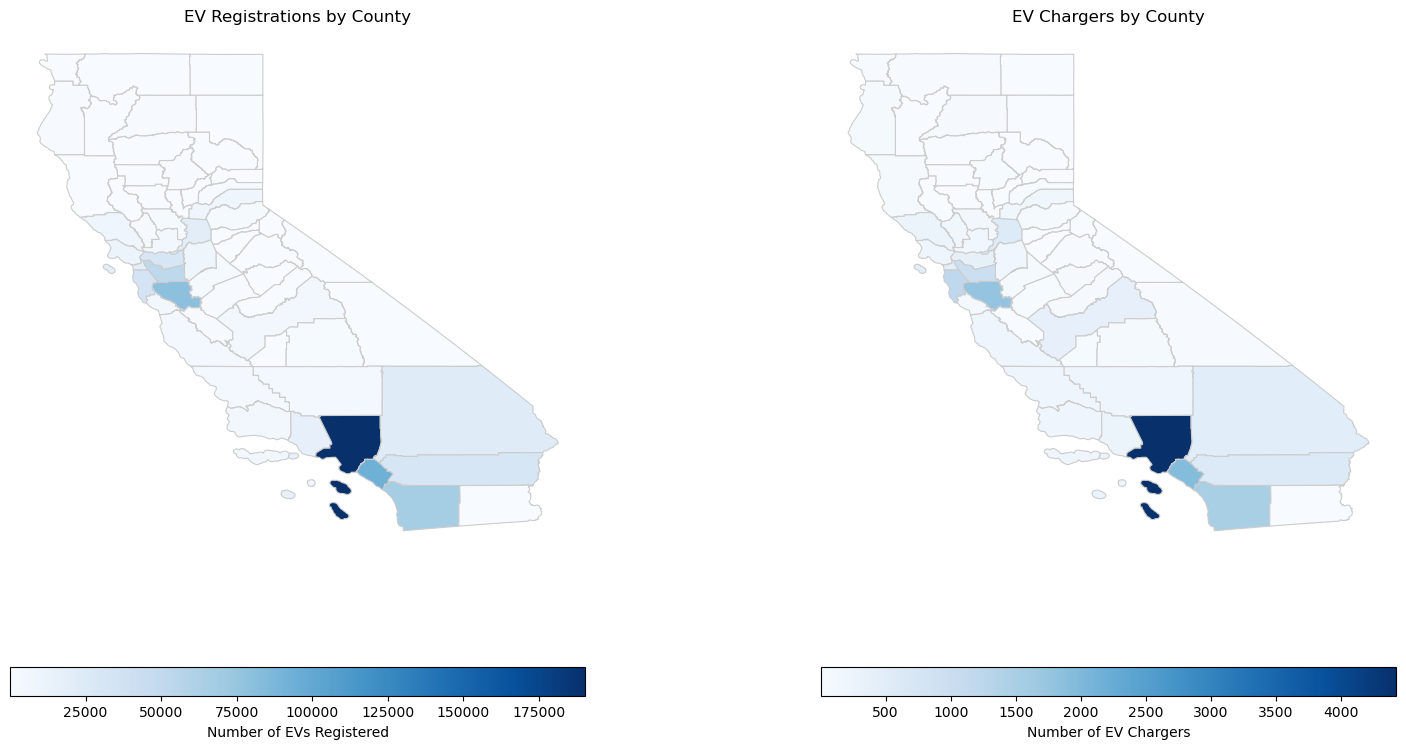

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

ca_evs_2022.plot(column='Number of EVs', cmap='Blues', linewidth=0.8, ax=axs[0], edgecolor='0.8', legend=True,
                 legend_kwds={'label': "Number of EVs Registered", 'orientation': "horizontal", 'shrink': 0.6})
axs[0].set_title('EV Registrations by County')
axs[0].set_axis_off()

county_shp_charging.plot(column='chrgs_count', cmap='Blues', linewidth=0.8, ax=axs[1], edgecolor='0.8', legend=True,
                         legend_kwds={'label': "Number of EV Chargers", 'orientation': "horizontal", 'shrink': 0.6})
axs[1].set_title('EV Chargers by County')
axs[1].set_axis_off()

plt.tight_layout()
plt.show()

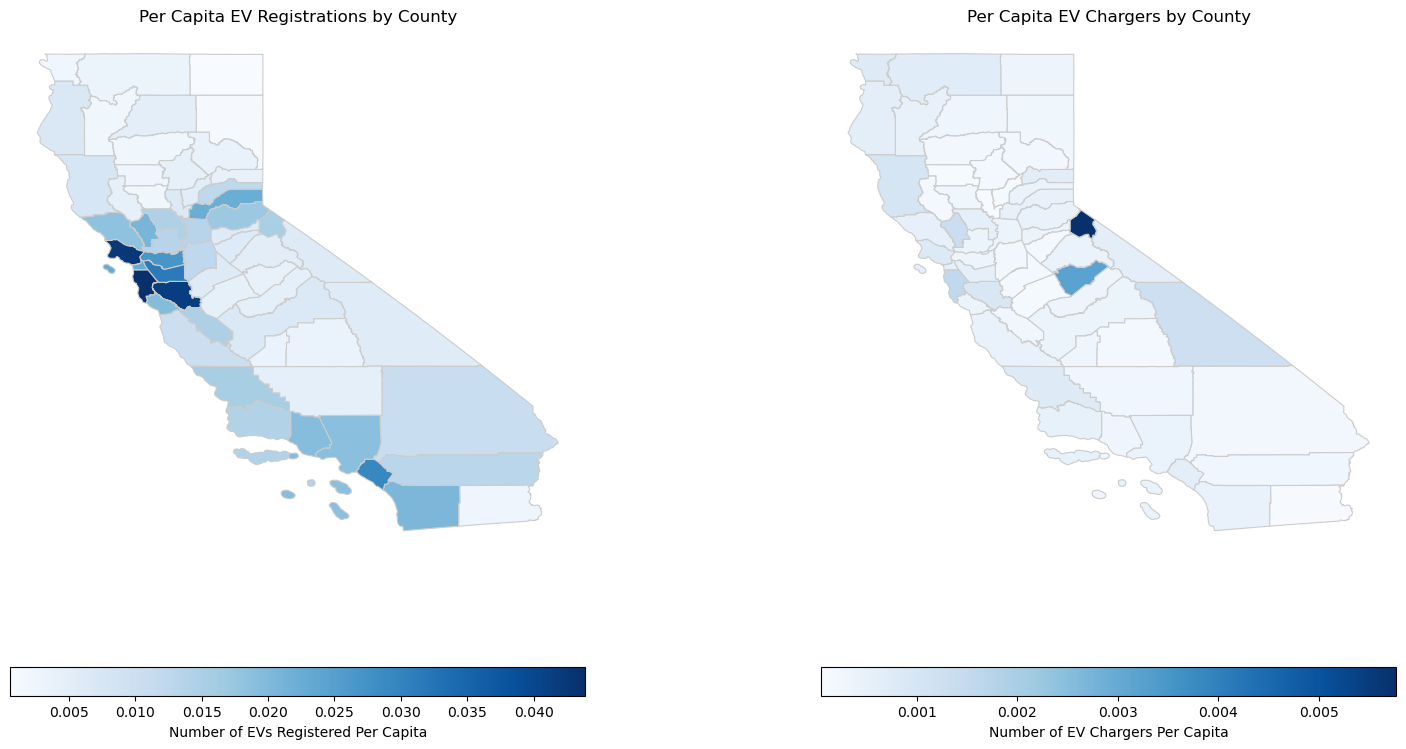

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

evs_by_pop.plot(column='EV Per Capita', cmap='Blues', linewidth=0.8, ax=axs[0], edgecolor='0.8', legend=True,
                legend_kwds={'label': "Number of EVs Registered Per Capita", 'orientation': "horizontal", 'shrink': 0.6})
axs[0].set_title('Per Capita EV Registrations by County')
axs[0].set_axis_off()

chrgs_by_pop.plot(column='EV Chargers Per Capita', cmap='Blues', linewidth=0.8, ax=axs[1], edgecolor='0.8', legend=True,
                  legend_kwds={'label': "Number of EV Chargers Per Capita", 'orientation': "horizontal", 'shrink': 0.6})
axs[1].set_title('Per Capita EV Chargers by County')
axs[1].set_axis_off()

plt.tight_layout()
plt.show()

In [33]:
#dropping alpine, mariposa, and inyo counties -- top 3 for chargers
chrgs_bypop_no_ami = chrgs_by_pop.drop([25, 19, 12], axis=0)

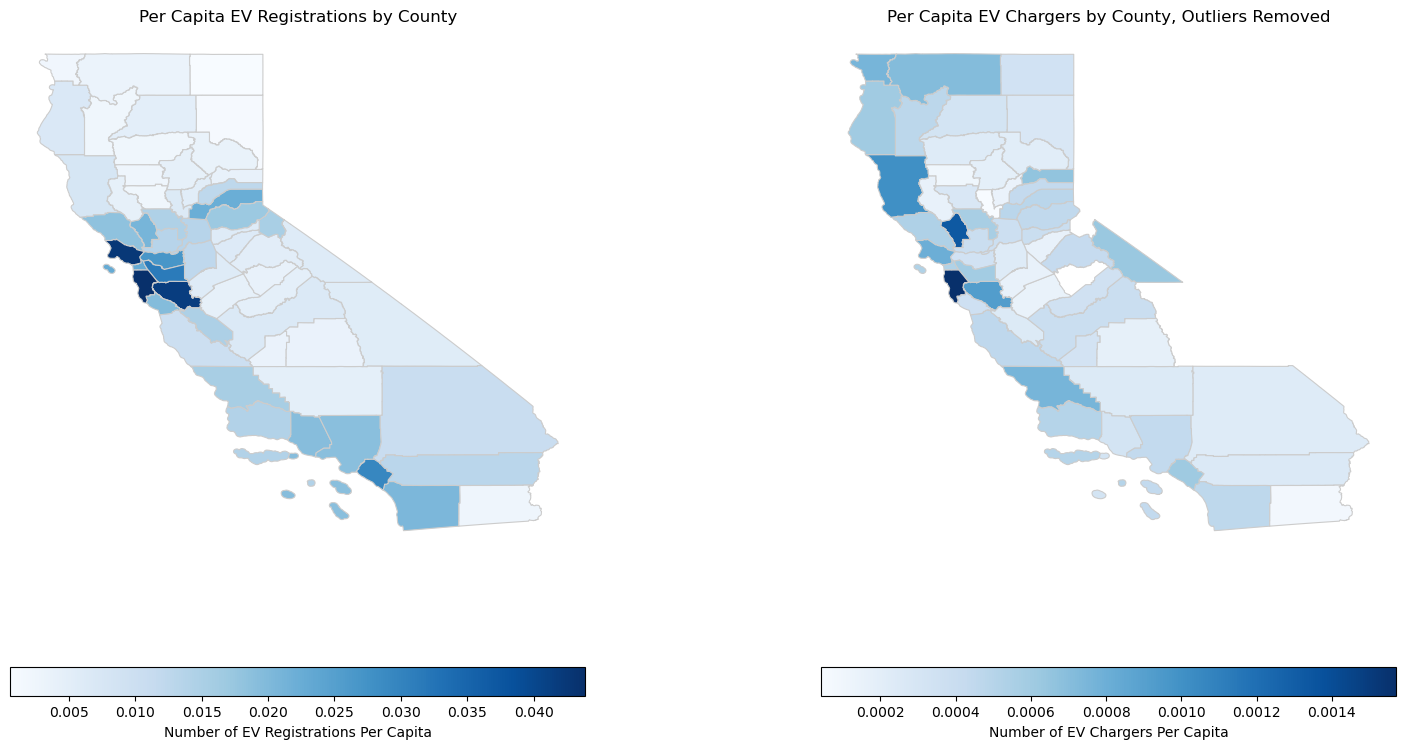

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

evs_by_pop.plot(column='EV Per Capita', cmap='Blues', linewidth=0.8, ax=axs[0], edgecolor='0.8', legend=True,
                legend_kwds={'label': "Number of EV Registrations Per Capita", 'orientation': "horizontal", 'shrink': 0.6})
axs[0].set_title('Per Capita EV Registrations by County')
axs[0].set_axis_off()

chrgs_bypop_no_ami.plot(column='EV Chargers Per Capita', cmap='Blues', linewidth=0.8, ax=axs[1], edgecolor='0.8', legend=True,
                  legend_kwds={'label': "Number of EV Chargers Per Capita", 'orientation': "horizontal", 'shrink': 0.6})
axs[1].set_title('Per Capita EV Chargers by County, Outliers Removed')
axs[1].set_axis_off()

plt.tight_layout()
plt.show()